Notes:

- Will train static y[:1000], then decompose and predict step wise simulation.

In [4]:
from vmdpy import VMD
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
# need to create validation part of testing!

class vmd_lstm:

    def train_data(x_train, y_train, length=21):
        '''Train data generator. Can be many steps ahead forecast.
        '''
        data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_train,
            y_train,
            length=length,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=256
        )  # missing target length horizon (only manual setting)
        return data_gen
    
    def test_data(x_test, length=21):
        '''Test data should not leak target,
        y_test == np.zeros(len(x_test)).
        '''
        gen_day_ahead = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_test,
            np.zeros(len(x_test)),
            length=21,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=1
        )  # missing target length horizon (only manual setting)

        return gen_day_ahead
    
    def lstm(input_data, epochs=500, learning_rate=1e-3):
        '''Custom model LSTM-DNN.
        Returns keras.models.Sequential()
        formula and prints log(loss) plot for reference.
        '''
        model = keras.models.Sequential()
        # model.add(keras.layers.Input(shape=(21, 13)))
        # Can have CNN layer if we have many IMFs (test)
        model.add(LSTM(128, return_sequences=True, activation='relu'))
        model.add(LSTM(64, return_sequences=False, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss=['mse'])
        a = model.fit(input_data, shuffle=False, epochs=epochs, workers=-1, use_multiprocessing=True)
        plt.figure(figsize=(14,8))
        plt.plot(np.log1p(a.history['loss']))
        plt.title("log(Loss history)")
        plt.grid()

        return model
    
    def vmd(input_data, n_modes=13, alpha=200, tol=1e-20, plot=True):
        '''Input data and decompose it to n-modes.
        Function to be used in sensitivity analysis in pre-processing part.
        Returns decomposed_data , y_hat, omega.
        Use plot=False when grid searching for parameters.
        '''
        # Params  
        alpha = alpha  # quadratic penalty, high alpha == bias (sensitivity analysis)
        tau = 0.  # noise-tolerance (no strict fidelity enforcement)  
        K = n_modes  # modes count (sensitivity analysis)
        DC = 0  # no DC part imposed  
        init = 1  # initialize omegas uniformly  
        tol = tol  

        # VMD 
        modes, u_hat, omega = VMD(input_data, alpha, tau, K, DC, init, tol)  

        # Reconstruct data
        a = input_data
        reconstruct = np.sum(pd.DataFrame(modes))  # additive components; shape==(503, 13)
        rmse = np.sqrt(1/len(a) * np.sum(np.square(a-reconstruct)))
        mape = np.mean(np.abs(reconstruct/a-1))
    
        if plot == True:
            # Visualize decomposed modes
            plt.figure(figsize=(14,8))
            plt.subplot(2,1,1)
            plt.plot(input_data)
            plt.title('Original signal')
            plt.subplot(2,1,2)
            plt.plot(modes.T)
            plt.title('Decomposed modes')
            plt.legend(['Mode %d'%m_i for m_i in range(modes.shape[0])])
            plt.tight_layout()

            plt.figure(figsize=(14,8))
            plt.plot(a-reconstruct)
            plt.title("Reconstruction error")
            plt.figure(figsize=(14,8))
            plt.hist(a-reconstruct, bins='fd')

        return modes.T, rmse, mape
    
    def predict_test(x_test, len=21):
        '''x_test = Test data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 100 - len
        y_act = pd.Series(y[-offset_length:])  # uses global y
        y_pred = model.predict(x_test)  # weird format
        y_pred = pd.Series(y_pred.T[0])
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()

        return y_pred, y_act

    def predict_train(x_train, len=21):
        '''x_train = Train data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 1000 - len
        y_act = pd.Series(y[:1000]).shift(-21)
        y_pred = model.predict(data_gen)
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()
        
        return y_pred, y_act

Structure of tf.TimeseriesGenerator ex. (array([[0, 1, 2, 3, 4]]), array([5])) with padding (array([[0, 1, 2, 3, 4, 5]]), array([6])) 6th index# is unseen data t+1

Conclution: If we dont use pipeline with pre-processing -> modeling -> testing at each step, we are doing VMD wrong!

**Doing all dataset to IMFs and then slicing for test set is leaking the target into test set!**

Redo and organize:
- Pre-process/model/test unseen per steps and collect in for loop
- Organize all into one big for loop that will collect steps of predictions.

In [5]:
### Pipeline simulation

import yfinance as yf

# Download and prepare financial data
spy_df = yf.download(tickers = "SPY",  # list of tickers
                period = "5y",         # time period
                interval = "1d",       # trading interval
                prepost = False,       # download pre/post market hours data?
                repair = True)
spy_pct = np.log1p(spy_df["Adj Close"].pct_change().dropna())
spy_pct = np.array(spy_pct)

y_total = spy_pct


[*********************100%***********************]  1 of 1 completed


In [40]:
spy_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-27,267.000000,267.339996,265.500000,266.559998,244.783569,57053600
2018-04-30,267.260010,267.890015,264.429993,264.510010,242.901047,82182300
2018-05-01,263.869995,265.100006,262.109985,264.980011,243.332657,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,241.698044,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,241.165405,136311500
...,...,...,...,...,...,...
2023-04-20,411.209991,413.700012,410.269989,411.880005,411.880005,75840400
2023-04-21,412.190002,412.679993,410.170013,412.200012,412.200012,73436100
2023-04-24,411.989990,413.070007,410.600006,412.630005,412.630005,64332100


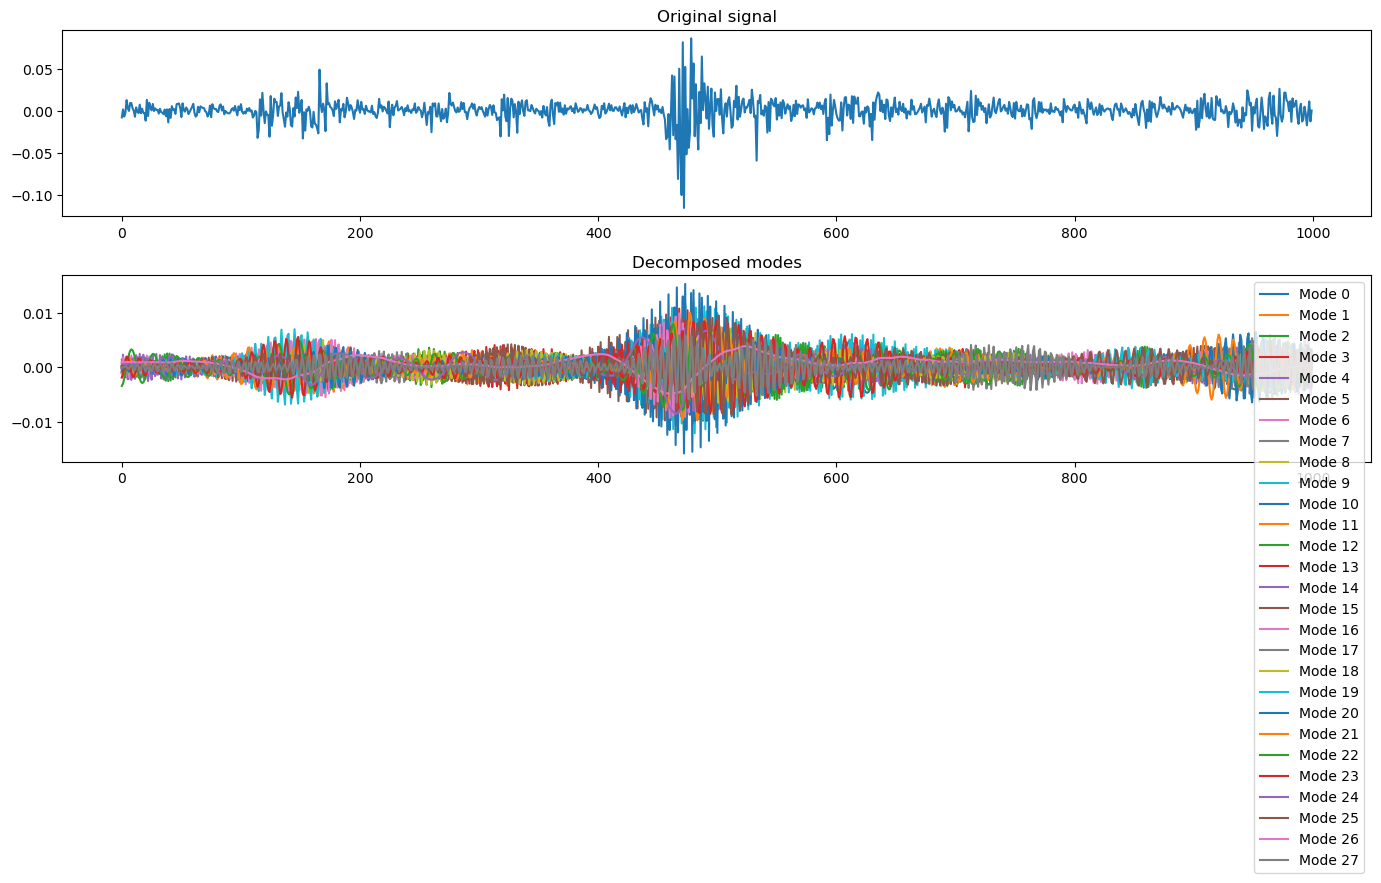

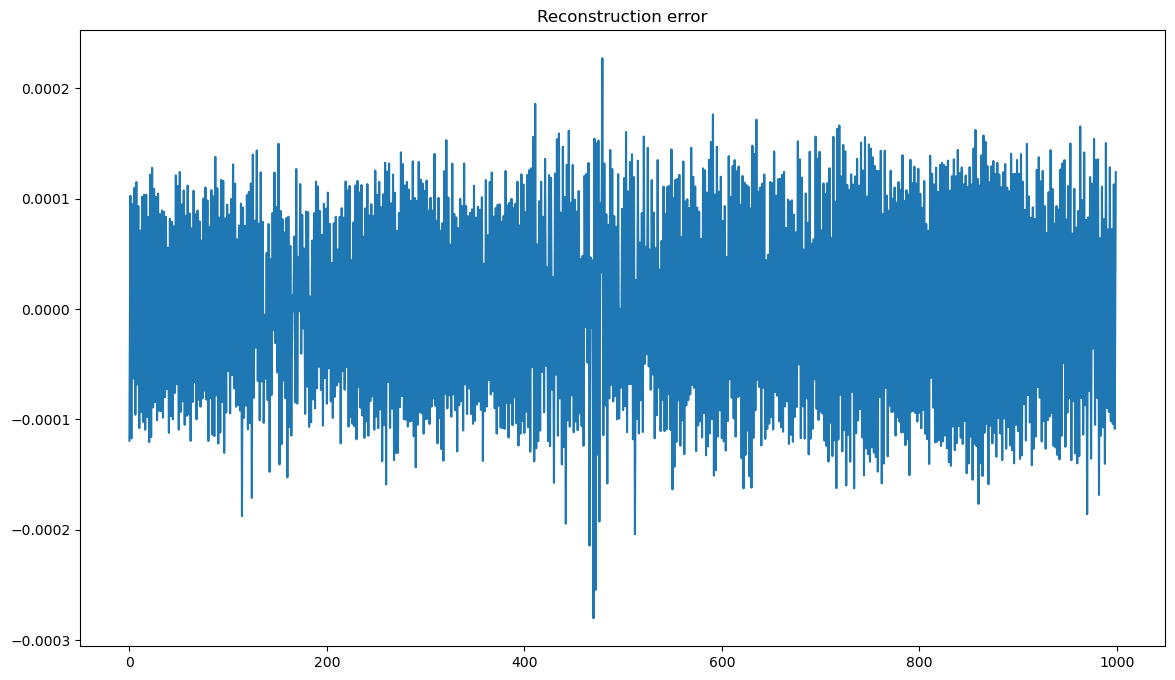

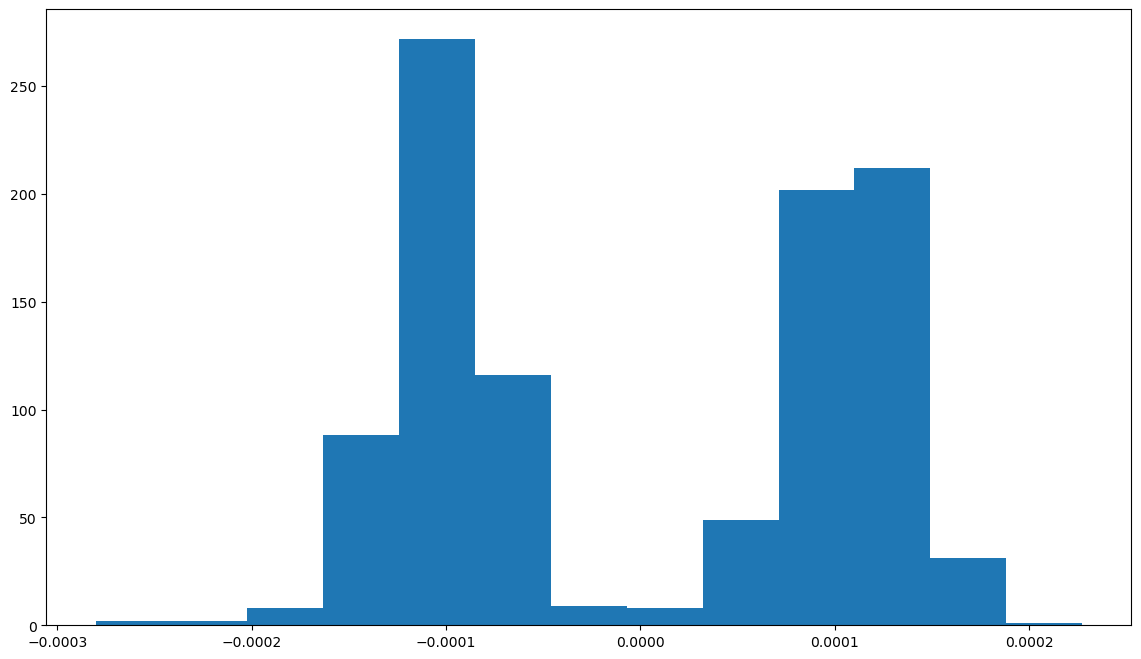

In [6]:
y = y_total
modes, _, _ = vmd_lstm.vmd(y[:1000], n_modes=28, alpha=100, plot=True)

27-04-2023

To do:
-debug what actually happens with data_gen and how to predict day_ahead correctly

In [104]:
try:
    y_a = spy_pct[len(spy_pct)]
except:
    y_a = "error"

Epoch 1/800
4/4 [==============================] - 5s 98ms/step - loss: 1.7836e-04
Epoch 2/800
4/4 [==============================] - 0s 93ms/step - loss: 1.7846e-04
Epoch 3/800
4/4 [==============================] - 0s 111ms/step - loss: 1.7818e-04
Epoch 4/800
4/4 [==============================] - 0s 91ms/step - loss: 1.7825e-04
Epoch 5/800
4/4 [==============================] - 0s 94ms/step - loss: 1.7821e-04
Epoch 6/800
4/4 [==============================] - 0s 93ms/step - loss: 1.7810e-04
Epoch 7/800
4/4 [==============================] - 0s 90ms/step - loss: 1.7803e-04
Epoch 8/800
4/4 [==============================] - 0s 98ms/step - loss: 1.7802e-04
Epoch 9/800
4/4 [==============================] - 0s 96ms/step - loss: 1.7799e-04
Epoch 10/800
4/4 [==============================] - 0s 102ms/step - loss: 1.7795e-04
Epoch 11/800
4/4 [==============================] - 0s 98ms/step - loss: 1.7793e-04
Epoch 12/800
4/4 [==============================] - 0s 100ms/step - loss: 1.7791e-0

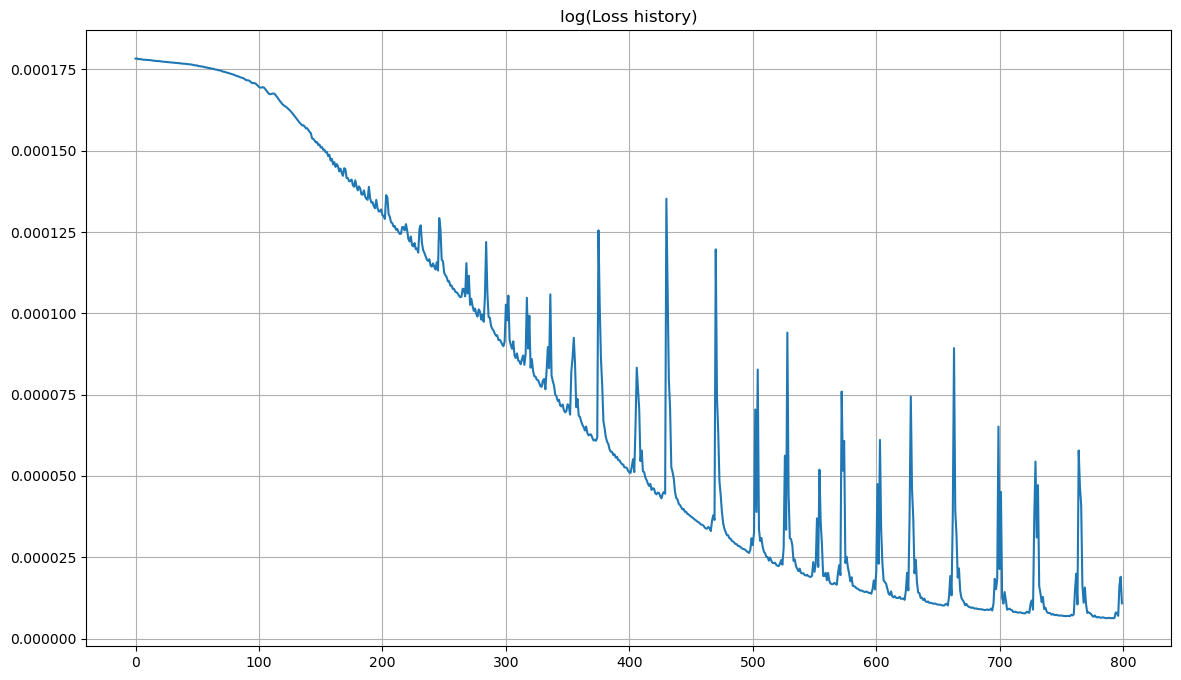

In [106]:
%%time

## Simulator
collect = []
index_end = list(range(1000, len(spy_pct), 1)) # index=1000 is the actual prediction
# index_start = list(range())
for i in index_end:
    # Prepare slice for vmd (vmd require even numbers)
    if (i%2) == 0:
        y = spy_pct[0:i]
    else:
        y = spy_pct[1:i]

    # Except when spy_pct goes t+1 (out of index at the end)
    try:
        y_1 = spy_pct[i+1]  # get actual target t+1 to compare with y_pred unseen
    except:
        y_1 = np.nan  # out of index == NaN

    # IMFs input data (vmd param search)
    n_modes = 29
    alpha = 50
    modes, _, _ = vmd_lstm.vmd(y, n_modes=n_modes, alpha=alpha, plot=False)  # n_modes=K

    # Prepare train data
    x_train, y_train = modes, y
    data_gen = vmd_lstm.train_data(x_train, y_train)
    
    # Train (only initially)
    if i == 1000:
        model = vmd_lstm.lstm(data_gen, epochs=800, learning_rate=1e-4)
    #     # Save trained model
    #     param = "VMD{}-{}_LSTM800-1e4".format(n_modes, alpha)
    #     model.save_weights('C:/Users/dminc/Desktop/vmd-lstm/saved_weights/{}'.format(param))
    # # Load saved model
    # model = model.load_weights('./saved_weights/')

    # # Pred seen data (optional)
    # y_pred, y_act = vmd_lstm.predict_train(data_gen)

    # Prepare test data
    x_test = np.concatenate([modes[-21:], [np.zeros(n_modes)]])  #22 rows in order to work with tf.tsgen(len=21)
    data_gen_dayahead = vmd_lstm.test_data(x_test)  # take y_total outside of the loop for comparison

    # Predict t+1
    step_ahead = model.predict(data_gen_dayahead)  # this will pred t+1 == index(1000) !
    collect.append([i, step_ahead, y_1])

In [135]:
collect_df = pd.DataFrame(collect)
collect_df.to_csv("simulator_collect.csv")  # currently every second day in order to meet VMD criteria of even decomposition

In [139]:
simulator_result = pd.read_csv("simulator_collect.csv")

In [140]:
simulator_result

,y_index,y_pred_sim,y_pred_act
0,1000,0.005246,-0.000742
1,1001,0.020815,-0.015067
2,1002,0.008310,-0.027823
3,1003,-0.010228,0.005781
4,1004,-0.022097,-0.029388
...,...,...,...
252,1252,0.006032,0.000777
253,1253,-0.001063,0.001043
254,1254,0.004861,-0.016001
255,1255,0.004413,-0.004245


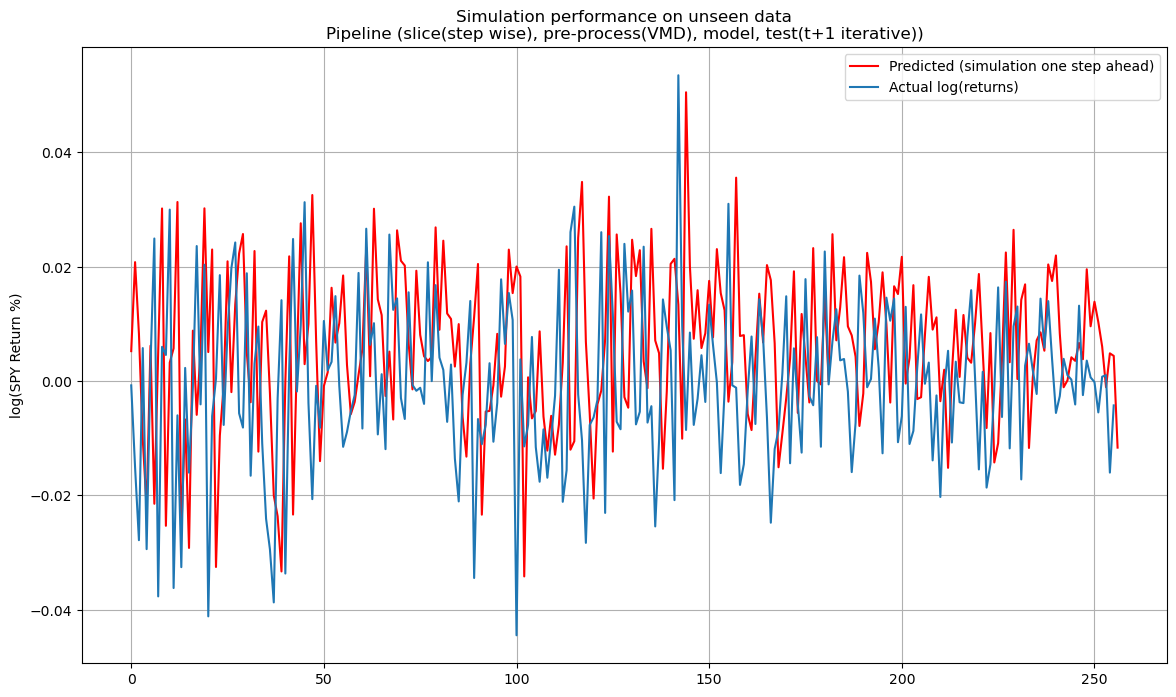

In [150]:
# Predict every second day(vmd constrains) -> t+1
plt.figure(figsize=(14, 8))
plt.plot(simulator_result.y_pred_sim, c='r', label='Predicted (simulation one step ahead)')
plt.plot(simulator_result.y_pred_act, label="Actual log(returns)")
plt.title("Simulation performance on unseen data\nPipeline (slice(step wise), pre-process(VMD), model, test(t+1 iterative))")
plt.ylabel("log(SPY Return %)")
plt.legend()
plt.grid()

27-04-2023

**Conclution:**
-Why do we have t+1 prediction and still y_actual to compare? We must have leading y_pred but we have not currently. - fixed by except gate on y_1

**Result:**
- Best prediction according to the model is the yesterday price.

In [13]:
# Problem (decomposing odd amount of rows leads to one less row in modes dataset)
y_total = y_total[:1001]
modes = vmd_lstm.vmd(y_total, n_modes=29, alpha=50, plot=False)
display(pd.DataFrame(modes).shape)
display(pd.DataFrame(y_total).shape)

(1000, 29)

(1001, 1)

Note: Potential fix with odd number problem for decomposition can be shifting between first slice index y[0/1:n]
- no need we proofed that this model is useless with predicting t+1 unseen data based on 30 IMFs derivative features.